In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# reproducing simulated data from Moody 2001

## random walk with autoregressive trend

[1] J. Moody and M. Saffell, “Learning to trade via direct reinforcement,” IEEE Trans. Neural Networks, vol. 12, no. 4, pp. 875–889, 2001.

In [147]:
T=10000
alpha=0.9
k=3

eps = np.random.randn(T)
v = np.random.randn(T)
z = np.zeros(T)
p = np.zeros(T)
beta = np.zeros(T)
p[0] = 1

In [148]:
for t in range(1, T):
    p[t] = p[t-1] + beta[t-1] + k*eps[t]
    beta[t] = alpha * beta[t-1] + v[t]
    
#     R = np.max(p[:t+1]) - np.min(p[:t+1])
#     z[t] = np.exp(p[t] / R)
R = np.max(p) - np.min(p)
z = np.exp(p / R)

tick_data = z

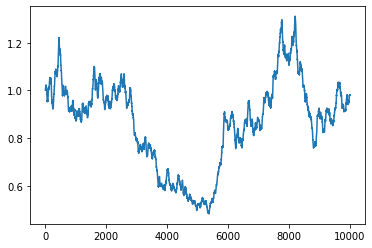

In [149]:
plt.plot(z)

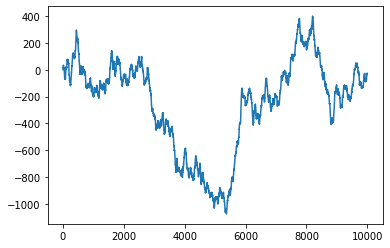

In [150]:
plt.plot(p)

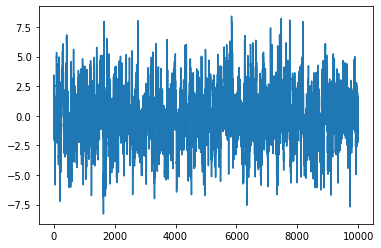

In [151]:
plt.plot(beta)

# Moody RRL trader

### Policy
$F_t = F(\theta_t;F_{t-1};I_t;\epsilon_t)$

$F_t = tanh[<\theta,I_t>+b+uF_{t-1}]$

$F_t \in \{1,0,-1\}$

Because the system is already noisy, the epsilon term can be omitted. $\epsilon_t \sim p_\epsilon(\epsilon)$


### State/Observation

Observation at time $t$ contains $m$ prices from $t$ to $t-m+1$ and other indicators

$I_t = \{z_t, z_{t-1}, z_{t-2}, ...;y_t,y_{t-1},y_{t-2},...\}$

### Reward function
$R_t = \mu\{F_{t-1}r_t-\delta|F_t-F_{t-1}|\}$

$r_t = z_t-z_{t-1}$

$\mu$ is fixed trading quantity

$\delta$ is the transaction cost

### Performance functions

#### To maximise wealth as accumulated profits plus starting capital:
$$U_T = W_0 + \sum_{t=1}^TR_t$$

$D_t\propto \Delta U_t=U_t-U_{t-1}$

#### To maximise risk-adjusted return, Sharpe Ratio:
$U_T = S_T = \dfrac{Average(R_t)}{Standard Deviation(R_t)}$

$D_t \equiv \dfrac{dS_t}{d\eta}=\dfrac{B_{t-1}\Delta A_t - \frac{1}{2} A_{t-1}\Delta B_t}{(B_{t-1}-A_{t-1}^2)^{3/2}}$

$A_t=A_{t-1}+\eta\Delta A_t=A_{t-1}+\eta(R_t-A_{t-1})$

$B_t=B_{t-1}+\eta\Delta B_t=B_{t-1}+\eta(R_t^2-B_{t-1})$

$\eta$ is the adaption rate, $A_t$ and $B_t$ are exponential moving estimates of first and second moments of $R_t$

### Optimisation

$$\max_{\theta} U_T$$


Update the policy parameters with gradient ascent
$\Delta\theta=\rho\dfrac{dU_T(\theta)}{d\theta}$
Where $\rho$ is the learning rate

$$\frac{dU_T(\theta)}{d\theta}=\sum_{t=1}^T\frac{dU_T}{dR_t}\left\{\frac{dR_t}{dF_t}\frac{dF_t}{d\theta}+\frac{dR_t}{dF_{t-1}}\frac{dF_{t-1}}{d\theta}\right\}$$

$$\frac{dF}{d\theta}\approx\frac{\partial F}{\partial \theta}+\frac{\partial F}{\partial F_{t-1}}\frac{dF_{t-1}}{d\theta_{t-1}}$$


The derivatives and partial derivatives using the chain rule are:


$\frac{dR_t}{dF_t}=-\mu\delta\cdot  sign(F_t-F_{t-1})$

$\frac{dR_t}{dF_{t-1}}=\mu r_t + \mu\delta\cdot sign(F_t-F_{t-1})$



$\frac{\partial F_t}{\partial \theta_t} = (1-tanh^2(\theta_t\cdot I))$

$\frac{\partial F_t}{\partial F_{t-1}} = (1-tanh^2(\theta_t\cdot I))$


$\frac{dF_t}{d\theta_t} = (1-tanh^2(\theta_t\cdot I_t)) + (1-tanh^2(\theta_t\cdot I_t))\frac{dF_{t-1}}{d\theta_{t-1}}$

In [152]:
# eta = 0.01 # adaption rate for SR
T = 1000 # training size
TC = 0.0#02 #.002 # 0.005, 0.01  transaction costs
mu = 1.0 # trade quantity
m = 50 # number of prices in input feature window
theta = np.ones(m+2) # params are b,theta(m),u
# theta = np.random.rand(m+2)
rho = 0.02 # learning rate

z = tick_data[:T+m] # training prices

r = (z[1:]-z[:-1])/z[1:]
rn = (r - r.mean())/r.std()

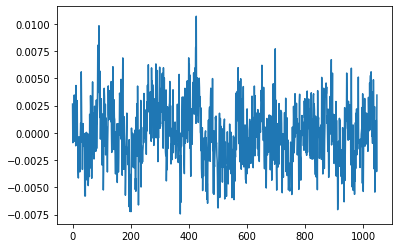

In [153]:
plt.plot(r)

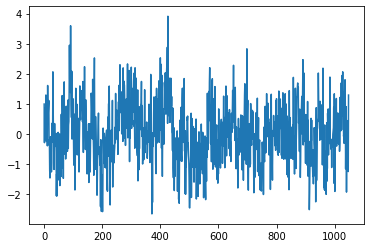

In [154]:
plt.plot(rn)

In [155]:
def get_action(theta, It):
#     print ('get_action', b, u, Ft_prev, I)
    e = 0.0# (np.random.rand()-0.5)*3.0
    return np.tanh(np.dot(theta, It)+e)

def get_reward(t, r, F, quantity = 1, transaction_costs = 0.002):
    r = z[t+m-1]-z[t+m-1-1]
    return quantity * (F[t-1] * r - transaction_costs * abs(F[t] - F[t-1]))

def get_price_obs(t):
    return rn[t:t+m]

def env_step(action):
    global t, F, R
#     print(t,F, '=', action)

    t += 1
    
#     if action > 0.3:
#         Ft = 1
#     elif action < -0.3:
#         Ft = -1
#     else:
#         Ft = 0
    F[t] = action
    
    
    
    Rt = get_reward(t, r, F, quantity=mu, transaction_costs=TC)
    R[t] = Rt
    
    It = np.concatenate([[1], get_price_obs(t), [F[t-1]]])
    
    done = t >= T
    
    return It, Rt, done

def env_reset():
    global t
    global F, R, dF
    t = 1
    F = np.zeros(T+1)
    dF = np.zeros([m+2,T+1])
    R = np.zeros(T+1)
    It = np.concatenate([[1], get_price_obs(t), [0]])
    return It

In [178]:
observation = env_reset()
num_epochs = 100
epoch = 1
total_reward = []
while (True):
    It = observation
    
    
    Ft = get_action(theta, It)
    
#     Ft = Ft if np.random.rand()>0.3 else Ft*-1
    
#     print (It,Ft)
    
    observation, reward, done = env_step(Ft)
    
#     print (It, Ft, reward)
    
#     if t>10:break
    
    if done:
        # print stats
        print (epoch, 'total reward=', np.sum(R))
        total_reward.append(np.sum(R))
        
        # train policy (gradient ascent)
        for i in range(1, T):
            dzn = get_price_obs(i)
        
            It = np.concatenate([[1], dzn, [F[i-1]]])
#             dF[:,i] = (1 - np.power(np.tanh(theta*It), 2))*(It + theta[m+1]*dF[:,i-1])
            dF[:,i] = (1 - np.power(np.tanh(theta*It), 2))+ (1 - np.power(np.tanh(theta*It), 2))*(dF[:,i-1])
#         print (theta)
#         print (dF[:,i])
        
        dRtdFt = -mu * TC * np.sign(F[1:t] - F[0:t-1])
        dRtdFt1 = mu * (r[m:m+t-1] + TC * np.sign(F[1:t] - F[0:t-1])) 
#         dF[:,t] = (1 - np.power(np.tanh(theta*It), 2))*(It + mu*dF[:,t-1])
        
        dUt = dRtdFt * dF[:,1:t] + dRtdFt1 * dF[:,0:t-1]
        
#         print (np.sum(dRtdFt1), np.sum(dUt,1))
#         print(dF)
        theta = theta + rho * np.sum(dUt,1)
#         print(np.sum(dUt,1))
#         print (theta)
        
        # start next epoch/episode
        epoch += 1
        if epoch > num_epochs:
            break
        observation = env_reset()
#         break

1 total reward= -0.24527602349214064
2 total reward= -0.24531197994514164
3 total reward= -0.24534793414942838
4 total reward= -0.2453838856541582
5 total reward= -0.24541983399616926
6 total reward= -0.24545577870029112
7 total reward= -0.24549171927964764
8 total reward= -0.24552765523595207
9 total reward= -0.24556358605979456
10 total reward= -0.24559951123092227
11 total reward= -0.24563543021851292
12 total reward= -0.24567134248144187
13 total reward= -0.2457072474685423
14 total reward= -0.24574314461886015
15 total reward= -0.24577903336190204
16 total reward= -0.24581491311787945
17 total reward= -0.2458507832979458
18 total reward= -0.2458866433044291
19 total reward= -0.24592249253106052
20 total reward= -0.2459583303631967
21 total reward= -0.24599415617803902
22 total reward= -0.24602996934484744
23 total reward= -0.24606576922515128
24 total reward= -0.24610155517295546
25 total reward= -0.24613732653494275
26 total reward= -0.24617308265067317
27 total reward= -0.246208

In [169]:
tick_data.shape, T, m, z.shape, r.shape

((10000,), 1000, 50, (1050,), (1049,))

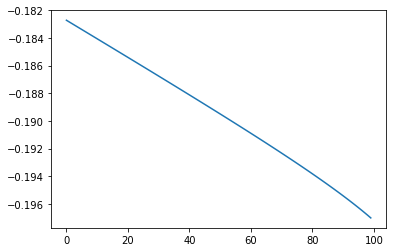

In [170]:
plt.plot(total_reward)

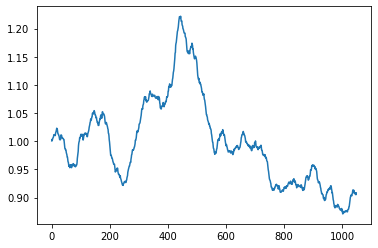

In [171]:
plt.plot(z)

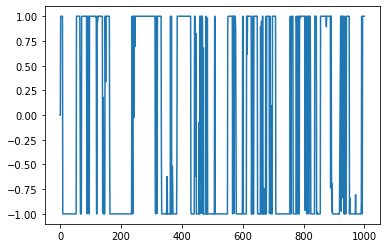

In [172]:
plt.plot(F)

In [161]:
theta

array([-0.63305193,  1.18323337,  1.14877414,  1.39510952,  0.7608192 ,
        0.65164573,  1.72506028,  1.23199326,  1.70920202,  1.93780844,
        1.87445098,  1.84431386,  1.34080476,  2.06872195,  1.51570494,
        1.59733555,  1.84963464,  1.37365268,  0.96943472,  0.7555848 ,
        0.62956703,  0.42074852, -1.57885187, -0.98434878,  0.33068057,
       -0.39941664,  1.37046919,  1.61711099,  1.45011683,  0.77160747,
        1.05061347,  1.4040013 ,  1.10046896,  1.71512608,  1.59843176,
        1.29442114,  1.07655671,  1.27710505,  0.79413208,  0.81730951,
        0.7267095 ,  0.79733203,  0.4590725 , -1.97353086, -1.30269265,
       -0.97792514, -2.0201849 , -1.0244643 , -0.97541717, -1.6175756 ,
       -0.78449861,  0.60166891])

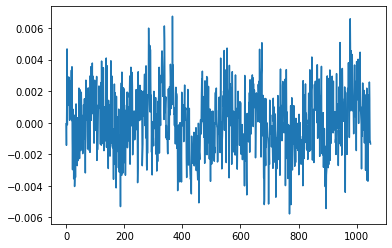

In [140]:
plt.plot(r)

In [141]:
np.sum(F[1:-1]*r[m:])

0.38184996303439006

In [142]:
theta

array([1.19561652, 1.56774   , 1.72282517, 1.54642479, 1.48405956,
       1.39398256, 1.50269941, 1.64150367, 1.44332431, 1.50339097,
       1.20877912, 1.31956826, 1.27426009, 1.50298986, 1.44194824,
       1.37704725, 1.39379749, 1.48983852, 1.58848603, 1.39829022,
       1.54259851, 1.41936807, 1.44951984, 1.43643539, 1.38978715,
       1.33052418, 1.632309  , 1.71821711, 1.53738438, 1.5069483 ,
       1.75663021, 1.61001181, 1.78037848, 1.63069347, 1.56032902,
       1.6391837 , 1.83624752, 1.86202035, 1.7277441 , 1.55272553,
       1.33614298, 1.4502044 , 1.49374756, 1.47485129, 1.48286849,
       1.60887951, 1.56985567, 1.37158271, 1.16948098, 1.02522364,
       1.18682321, 1.22626363])

1 total reward= 0.41074411242524234
2 total reward= 0.4106941129203137
3 total reward= 0.4106429868715494
4 total reward= 0.4105910644525593
5 total reward= 0.4105386735659616
6 total reward= 0.4104861324099871
7 total reward= 0.4104337424426233
8 total reward= 0.41038178228632616
9 total reward= 0.41033050294698814
10 total reward= 0.4102801245333822
11 total reward= 0.41023083449169384
12 total reward= 0.4101827872354749
13 total reward= 0.4101361049628461
14 total reward= 0.4100908794082746
15 total reward= 0.410047174267813
16 total reward= 0.41000502805391265
17 total reward= 0.4099644571686752
18 total reward= 0.40992545902425626
19 total reward= 0.40988801507993816
20 total reward= 0.4098520937031829
21 total reward= 0.4098176527945836
22 total reward= 0.4097846421432325
23 total reward= 0.40975300549962
24 total reward= 0.40972268236834364
25 total reward= 0.4096936095334163
26 total reward= 0.4096657223357099
27 total reward= 0.4096389557258679
28 total reward= 0.4096132451176

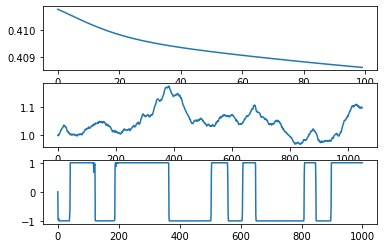

In [143]:
from importlib import reload 
import moody_DRL_trader
reload(moody_DRL_trader)
agent, env = moody_DRL_trader.training(z)

In [144]:
s = list(range(10))
s

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [145]:
mm=2
t=0
s[t:t+mm]

[0, 1]

In [146]:
s[-1]

9

In [53]:
It

array([ 1.        , -1.68146789, -1.41601924,  1.33049331,  0.47498857,
        0.43655306, -1.215883  , -0.08623461,  1.64224582,  0.15438233,
        0.66229298, -0.39701604, -1.29938658,  0.3259969 ,  1.59327621,
        1.40218794,  0.44087974,  0.26325211,  0.90967276,  0.37046899,
       -0.05465043,  0.41529713,  0.78255233,  1.51029442, -0.44046579,
       -0.43188702,  1.05861675, -0.7919053 , -0.2349625 , -1.5180994 ,
        0.50683352,  0.46926084, -0.17646706,  2.15550502,  0.53894096,
        1.4512079 ,  0.79545818, -0.09883457, -0.06320418, -0.57246763,
       -0.2896832 , -0.37461668, -1.21111802,  0.4067591 , -0.99267275,
       -0.67956522, -0.93187628,  0.67201191,  0.30028431, -0.09008574,
       -0.52231972,  1.        ])

In [58]:
agent.I[-5]

array([ 1.00000000e+00, -6.33800570e-03, -1.03293736e-03, -9.51443841e-04,
        2.94253067e-03, -4.67369474e-03, -3.92826458e-03,  3.78446370e-03,
        1.38204408e-03,  1.27410990e-03, -3.36624405e-03, -1.93977072e-04,
        4.65992388e-03,  4.81720941e-04,  1.90803041e-03, -1.06671026e-03,
       -3.60073792e-03,  9.63647227e-04,  4.52240793e-03,  3.98579581e-03,
        1.28626002e-03,  7.87447956e-04,  2.60271977e-03,  1.08853329e-03,
       -1.05282684e-04,  1.21441920e-03,  2.24574147e-03,  4.28937932e-03,
       -1.18872541e-03, -1.16463460e-03,  3.02098273e-03, -2.17563422e-03,
       -6.11633180e-04, -4.21492501e-03,  1.47147076e-03,  1.36595954e-03,
       -4.47366913e-04,  6.10125307e-03,  1.56163452e-03,  4.12345317e-03,
        2.28198356e-03, -2.29360154e-04, -1.29303261e-04, -1.55941163e-03,
       -7.65299289e-04, -1.00380863e-03, -3.35286308e-03,  1.19044281e-03,
       -2.73942732e-03, -1.86016197e-03, -2.56869931e-03,  9.84728779e-01])

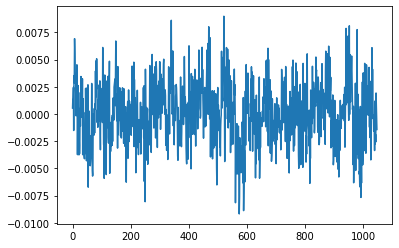

In [59]:
plt.plot(env.r)

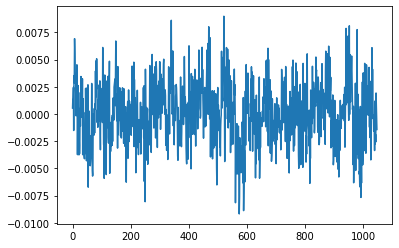

In [60]:
plt.plot(r)

In [67]:
np.sum(rn-moody_DRL_trader.normalise(agent.r))

0.0

In [72]:
agent.I[2]

array([ 1.00000000e+00,  1.40867985e-03,  2.44787180e-03, -1.51106793e-03,
        3.53647700e-03,  2.86635951e-03,  6.93072460e-03,  5.55893962e-03,
        3.51302269e-03,  3.30868316e-03,  3.62339113e-03, -1.57736474e-04,
        1.90417802e-03,  3.26959309e-03,  4.52672982e-03, -2.90077876e-04,
       -3.73130317e-03, -5.58197092e-04,  2.62185922e-03, -1.54365471e-03,
        1.98163584e-03, -3.75693786e-03, -2.39827919e-03, -3.65586240e-03,
       -2.87149097e-03,  5.08966213e-04, -1.11739474e-03,  1.28208116e-03,
        3.45230656e-03,  1.26231703e-03,  2.69364979e-03,  2.52825575e-03,
       -3.12774447e-04,  3.24157076e-03, -3.73504843e-03,  1.41910217e-03,
        5.01076720e-05,  1.59037751e-04,  3.40498196e-05, -3.88036603e-03,
       -4.10970919e-03, -1.80877366e-03, -3.63383160e-03, -3.24171006e-03,
        2.36239859e-03, -4.89040483e-04, -5.83339091e-04, -4.29482222e-03,
       -1.87633060e-03, -2.42032250e-03,  2.43598018e-03,  8.94334068e-01])

In [71]:
get_price_obs(2)

array([ 4.84473599e-01,  8.54531202e-01, -5.55252378e-01,  1.24218493e+00,
        1.00355522e+00,  2.45088091e+00,  1.96238649e+00,  1.23383282e+00,
        1.16106724e+00,  1.27313516e+00, -7.33292888e-02,  6.60921141e-01,
        1.14714722e+00,  1.59481524e+00, -1.20456234e-01, -1.34588103e+00,
       -2.15933835e-01,  9.16488346e-01, -5.66856573e-01,  6.88503969e-01,
       -1.35500958e+00, -8.71189460e-01, -1.31901647e+00, -1.03970079e+00,
        1.64084404e-01, -4.15064845e-01,  4.39391640e-01,  1.21221172e+00,
        4.32353609e-01,  9.42053061e-01,  8.83156029e-01, -1.28538512e-01,
        1.13716843e+00, -1.34721472e+00,  4.88185001e-01,  6.84281524e-04,
        3.94744240e-02, -5.03394056e-03, -1.39896251e+00, -1.48063190e+00,
       -6.61265775e-01, -1.31117128e+00, -1.17153629e+00,  8.24094079e-01,
       -1.91307077e-01, -2.24886933e-01, -1.54655089e+00, -6.85322890e-01,
       -8.79039113e-01,  8.50296581e-01])

In [73]:
m

50

In [74]:
agent.m

50

In [75]:
env.m

50

In [76]:
t

0

In [79]:
t=10
rn[t:t+m]

array([ 1.16106724e+00,  1.27313516e+00, -7.33292888e-02,  6.60921141e-01,
        1.14714722e+00,  1.59481524e+00, -1.20456234e-01, -1.34588103e+00,
       -2.15933835e-01,  9.16488346e-01, -5.66856573e-01,  6.88503969e-01,
       -1.35500958e+00, -8.71189460e-01, -1.31901647e+00, -1.03970079e+00,
        1.64084404e-01, -4.15064845e-01,  4.39391640e-01,  1.21221172e+00,
        4.32353609e-01,  9.42053061e-01,  8.83156029e-01, -1.28538512e-01,
        1.13716843e+00, -1.34721472e+00,  4.88185001e-01,  6.84281524e-04,
        3.94744240e-02, -5.03394056e-03, -1.39896251e+00, -1.48063190e+00,
       -6.61265775e-01, -1.31117128e+00, -1.17153629e+00,  8.24094079e-01,
       -1.91307077e-01, -2.24886933e-01, -1.54655089e+00, -6.85322890e-01,
       -8.79039113e-01,  8.50296581e-01, -8.73086694e-01,  9.40063658e-01,
       -2.41100610e+00, -5.41753320e-01, -9.41653566e-01,  7.81210448e-02,
       -1.16676088e+00, -1.68833099e+00])

In [82]:
moody_DRL_trader.normalise(env.r[t:t+m]).shape

(50,)